# classes

> This module has commands to handle the ```Box``` and ```Line``` classes that are loaded into and saved from the figure first outline in ```annotation```

In [ ]:
#| default_exp manuscriptFiles

In [ ]:
#| hide
from nbdev.showdoc import *

In [30]:
#| export

## Box

This class is designed to carry all the data for a ```Rectangle``` object to be drawn on ```Plotly``` figures. Details on that are in [documentation](https://plotly.com/python/shapes/). In order to instantiate a rectangle of the style we want, we need to run the following code:
```python
fig.add_shape(type="rect",
              x0=...,
              y0=...,
              x1=...,
              y1=...,
              line=dict(color="grey"),
              opacity = 0.6,
             )
```

The dotted out variables are the ones we want to assign uniquely and the rest are class level attributes. In addition to this though, we want each ```Box``` object related to a particular image to have an index that orders it and a text line that it is assigned to. This means that we can enumerate some traits.

#### Class Level Traits
- ```type``` corresponds to the type of figure being added
- ```line``` is a ```dict``` containing the line color
- ```opacity``` defines the opacity of the line of the shape

#### Object Level Traits
- ```x0``` corresponds to the $x$ coordinate of one corner
- ```y0``` corresponds to the $y$ coordinate of the same corner as $x_0$
- ```x1``` corresponds to the $x$ coordinate of the corner opposite $(x_0,y_0)$
- ```y1``` corresponds to the $y$ coordinate of the same corner as $x_1$
- ```line``` defines which line
- ```index``` defines the relative ordering of the

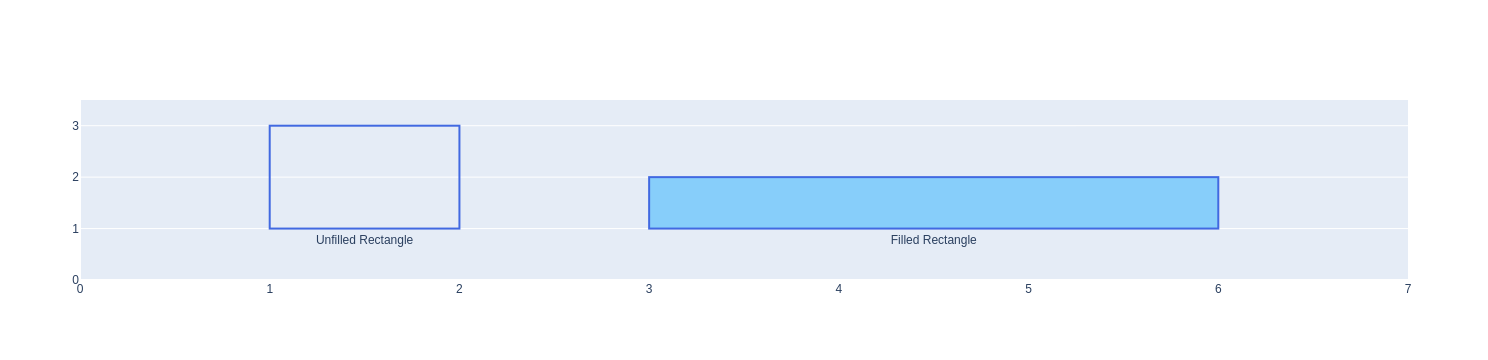

In [11]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1.5, 4.5],
    y=[0.75, 0.75],
    text=["Unfilled Rectangle", "Filled Rectangle"],
    mode="text",
))

# Set axes properties
fig.update_xaxes(range=[0, 7], showgrid=False)
fig.update_yaxes(range=[0, 3.5])

# Add shapes
fig.add_shape(type="rect",
    x0=2, y0=3, x1=1, y1=1,
    line=dict(color="RoyalBlue"),
)
fig.add_shape(type="rect",
    x0=3, y0=1, x1=6, y1=2,
    line=dict(
        color="RoyalBlue",
        width=2,
    ),
    fillcolor="LightSkyBlue",
)
fig.update_shapes(dict(xref='x', yref='y'))
fig.show()



In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()